In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['VL_ROOT_DIR'] = '/home/taehoonsong/HOILENS'
#%env CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from methods.llava_utils import retrieve_logit_lens_llava, load_llava_state,generate_llava_model, run_llava_model, get_phrase_embedding, generate_mass_edit_hook, remove_all_hooks
#from methods.blip_utils import retrieve_logit_lens_blip, load_blip_state
from methods.utils import load_images, string_to_token_ids
from methods.utils import load_image
from utils.hico_text_label import hico_text_label
from PIL import Image
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
    KeywordsStoppingCriteria,
)


/home/taehoonsong/.conda/envs/hoilens/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "llava7b" # or "blip7b"

if model_name.startswith("llava"):
    model_state = load_llava_state(0)
    retrieve_logit_lens = retrieve_logit_lens_llava
    tokenizer = model_state['tokenizer']
    lm_head = model_state["model"].lm_head.weight.detach().float()
    hidden_layer_embedding = model_state['hidden_layer_embedding']
    register_hook = model_state["register_hook"]
    #lm_head = torch.nn.functional.normalize(lm_head, dim=1)  # (N, D)
    embedding_matrix = model_state["model"].get_input_embeddings().weight.float()
elif model_name.startswith("blip"):
    model_state = load_blip_state()
    retrieve_logit_lens = retrieve_logit_lens_blip

/home/taehoonsong/.conda/envs/hoilens/lib/python3.8/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


In [3]:
import torch

verbs = [
    "adjust", "adjusting", "assemble", "assembling", "block", "blocking", "blow", "blowing", 
    "board", "boarding", "break", "breaking", "brush with", "brushing with", "buy", "buying", 
    "carry", "carrying", "catch", "catching", "chase", "chasing", "check", "checking", 
    "clean", "cleaning", "control", "controlling", "cook", "cooking", "cut", "cutting", 
    "cut with", "cutting with", "direct", "directing", "drag", "dragging", "dribble", "dribbling", 
    "drink with", "drinking with", "drive", "driving", "dry", "drying", "eat", "eating", 
    "eat at", "eating at", "exit", "exiting", "feed", "feeding", "fill", "filling", 
    "flip", "flipping", "flush", "flushing", "fly", "flying", "greet", "greeting", 
    "grind", "grinding", "groom", "grooming", "herd", "herding", "hit", "hitting", 
    "hold", "holding", "hop on", "hopping on", "hose", "hosing", "hug", "hugging", 
    "hunt", "hunting", "inspect", "inspecting", "install", "installing", "jump", "jumping", 
    "kick", "kicking", "kiss", "kissing", "lasso", "lassoing", "launch", "launching", 
    "lick", "licking", "lie on", "lying on", "lift", "lifting", "light", "lighting", 
    "load", "loading", "lose", "losing", "make", "making", "milk", "milking", "move", "moving", "no interaction", "no interaction",
    "open", "opening", "operate", "operating", "pack", "packing", 
    "paint", "painting", "park", "parking", "pay", "paying", "peel", "peeling", "pet", "petting", 
    "pick", "picking", "pick up", "picking up", "point", "pointing", "pour", "pouring", 
    "pull", "pulling", "push", "pushing", "race", "racing", "read", "reading", "release", "releasing", 
    "repair", "repairing", "ride", "riding", "row", "rowing", "run", "running", "sail", "sailing", 
    "scratch", "scratching", "serve", "serving", "set", "setting", "shear", "shearing", 
    "sign", "signing", "sip", "sipping", "sit at", "sitting at", "sit on", "sitting on", 
    "slide", "sliding", "smell", "smelling", "spin", "spinning", "squeeze", "squeezing", "stab", "stabbing", 
    "stand on", "standing on", "stand under", "standing under", "stick", "sticking", "stir", "stirring", 
    "stop at", "stopping at", "straddle", "straddling", "swing", "swinging", "tag", "tagging", 
    "talk on", "talking on", "teach", "teaching", "text on", "texting on", "throw", "throwing", 
    "tie", "tying", "toast", "toasting", "train", "training", "turn", "turning", "type on", "typing on", 
    "walk", "walking", "wash", "washing", "watch", "watching", "wave", "waving", "wear", "wearing", 
    "wield", "wielding", "zip", "zipping", #".", "."
]

verbs1 = [
    "adjust", "adjusted", "assemble", "assembled", "block", "blocked", "blow", "blown",
    "board", "boarded", "break", "broken", "brush with", "brushed with", "buy", "bought",
    "carry", "carried", "catch", "caught", "chase", "chased", "check", "checked",
    "clean", "cleaned", "control", "controlled", "cook", "cooked", "cut", "cut",
    "cut with", "cut with", "direct", "directed", "drag", "dragged", "dribble", "dribbled",
    "drink with", "drank with", "drive", "driven", "dry", "dried", "eat", "eaten",
    "eat at", "eaten at", "exit", "exited", "feed", "fed", "fill", "filled",
    "flip", "flipped", "flush", "flushed", "fly", "flown", "greet", "greeted",
    "grind", "grinded", "groom", "groomed", "herd", "herded", "hit", "hit",
    "hold", "held", "hop on", "hopped on", "hose", "hosed", "hug", "hugged",
    "hunt", "hunted", "inspect", "inspected", "install", "installed", "jump", "jumped",
    "kick", "kicked", "kiss", "kissed", "lasso", "lassoed", "launch", "launched",
    "lick", "licked", "lie on", "lain on", "lift", "lifted", "light", "lit",
    "load", "loaded", "lose", "lost", "make", "made", "milk", "milked", "move", "moved", "no interaction", "no interaction",
    "open", "opened", "operate", "operated", "pack", "packed",
    "paint", "painted", "park", "parked", "pay", "paid", "peel", "peeled", "pet", "petted",
    "pick", "picked", "pick up", "picked up", "point", "pointed", "pour", "poured",
    "pull", "pulled", "push", "pushed", "race", "raced", "read", "read", "release", "released",
    "repair", "repaired", "ride", "ridden", "row", "rowed", "run", "ran", "sail", "sailed",
    "scratch", "scratched", "serve", "served", "set", "set", "shear", "shorn",
    "sign", "signed", "sip", "sipped", "sit at", "sat at", "sit on", "sat on",
    "slide", "slid", "smell", "smelled", "spin", "spun", "squeeze", "squeezed", "stab", "stabbed",
    "stand on", "stood on", "stand under", "stood under", "stick", "stuck", "stir", "stirred",
    "stop at", "stopped at", "straddle", "straddled", "swing", "swung", "tag", "tagged",
    "talk on", "talked on", "teach", "taught", "text on", "texted on", "throw", "thrown",
    "tie", "tied", "toast", "toasted", "train", "trained", "turn", "turned", "type on", "typed on",
    "walk", "walked", "wash", "washed", "watch", "watched", "wave", "waved", "wear", "worn",
    "wield", "wielded", "zip", "zipped",
]
#verbs = ["adjust", "assemble", "block", "blow out", "board", "break", "brush with", "buy", "carry", "catch", "chase", "check", "clean", "control", "cook", "cut", "cut with", "direct", "drag", "dribble", "drink with", "drive", "dry", "eat", "eat at", "exit", "feed", "fill", "flip", "flush", "fly", "greet", "grind", "groom", "herd", "hit", "hold", "hop on", "hose", "hug", "hunt", "inspect", "install", "jump", "kick", "kiss", "lasso", "launch", "lick", "lie on", "lift", "light", "load", "lose", "make", "milk", "move", "no interaction", "open", "operate", "pack", "paint", "park", "pay", "peel", "pet", "pick", "pick up", "point", "pour", "pull", "push", "race", "read", "release", "repair", "ride", "row", "run", "sail", "scratch", "serve", "set", "shear", "sign", "sip", "sit at", "sit on", "slide", "smell", "spin", "squeeze", "stab", "stand on", "stand under", "stick", "stir", "stop at", "straddle", "swing", "tag", "talk on", "teach", "text on", "throw", "tie", "toast", "train", "turn", "type on", "walk", "wash", "watch", "wave", "wear", "wield", "zip"]
cls_index = [model_state['tokenizer'].encode(verb)[1:] for verb in verbs]
weights = []
with torch.no_grad():
    for idx in cls_index:
        temp = 0
        for i in idx:
            temp += lm_head[i].unsqueeze(0) #/ lm_head[i].unsqueeze(0).norm(p=2, dim=1, keepdim=True)
        weights.append(temp/len(idx))  # Normalizing as before
weights_tensor = torch.cat(weights, dim = 0) 
#ing_direction_all = ((weights_tensor[1::2, :]) - weights_tensor[0::2, :])
#ing_direction_all = ed_direction_all / torch.norm(ed_direction_all)
#x = weights_tensor[1::2, :].mean(0, keepdim=True)
# x = x / x.norm(p=2, dim=1, keepdim=True)
weights_tensor = (weights_tensor[1::2, :]) #+ weights_tensor[0::2, :])/2 #- weights_tensor[1::2, :].mean(0, keepdim=True)
#
# x = weights_tensor.mean(0, keepdim=True)
# x = x / x.norm(p=2, dim=1, keepdim=True)

cls_index = [model_state['tokenizer'].encode(verb)[1:] for verb in verbs1]
weights_ed1 = []
with torch.no_grad():
    for idx in cls_index:
        temp = 0
        for i in idx:
            temp += lm_head[i].unsqueeze(0) #/ lm_head[i].unsqueeze(0).norm(p=2, dim=1, keepdim=True)
        weights_ed1.append(temp/len(idx))  # Normalizing as before
weights_tensor1 = torch.cat(weights_ed1, dim = 0) 
#ed_direction_all = ((weights_tensor1[1::2, :]) - weights_tensor1[0::2, :])
#ed_direction_all = ed_direction_all / torch.norm(ed_direction_all)
weights_tensor1 = (weights_tensor1[1::2, :]) #+ weights_tensor1[0::2, :])/2 #- weights_tensor[1::2, :].mean(0, keepdim=True)



base_ind = [] #len 33
target_ind = []



base_ind1 = [] #len 33
target_ind1 = []

In [ ]:
torch.save(weights_tensor1, "verb_classifier_ed.pt")

In [3]:
def generate_images_tensor(model, img_path, image_processor):
    image_files = [img_path]
    images = load_images(image_files)
    image_sizes = [x.size for x in images]

    images_tensor = process_images(images, image_processor, model.config).to(
        model.device, dtype=torch.float16
    ).unsqueeze(0)

    return images_tensor, images, image_sizes
    
img_path = "/home/taehoonsong/HOILENS/hicodet/hico_20160224_det/images/test2015/HICO_test2015_00000005.jpg"
images_tensor, images, image_sizes = generate_images_tensor(
        model_state["model"], img_path, model_state["image_processor"]
)

In [5]:
verbs = [
    "adjusting", "assembling", "blocking", "blowing", "boarding", "breaking", "brushing with",
    "buying", "carrying", "catching", "chasing", "checking", "cleaning", "controlling",
    "cooking", "cutting", "cutting with", "directing", "dragging", "dribbling", "drinking with",
    "driving", "drying", "eating", "eating at", "exiting", "feeding", "filling", "flipping",
    "flushing", "flying", "greeting", "grinding", "grooming", "herding", "hitting", "holding",
    "hopping on", "hosing", "hugging", "hunting", "inspecting", "installing", "jumping",
    "kicking", "kissing", "lassoing", "launching", "licking", "lying on", "lifting", "lighting",
    "loading", "losing", "making", "milking", "moving", "not interacting", "opening", "operating",
    "packing", "painting", "parking", "paying", "peeling", "petting", "picking", "picking up",
    "pointing", "pouring", "pulling", "pushing", "racing", "reading", "releasing", "repairing",
    "riding", "rowing", "running", "sailing", "scratching", "serving", "setting", "shearing",
    "signing", "sipping", "sitting at", "sitting on", "sliding", "smelling", "spinning",
    "squeezing", "stabbing", "standing on", "standing under", "sticking", "stirring", "stopping at",
    "straddling", "swinging", "tagging", "talking on", "teaching", "texting on", "throwing",
    "tying", "toasting", "training", "turning", "typing on", "walking", "washing", "watching",
    "waving", "wearing", "wielding", "zipping"
]
all_token_ids = []
for i in range(0, len(verbs)):
    hidden_states, output, generated_ids, _ = generate_llava_model(
        model_state,
        model_state["model_name"],
        None,
        image_sizes,
        model_state["tokenizer"],
        hidden_states=False,
        text_prompt=f"Provide 5 single word auxiliary actions that can be visually identified with a person {verbs[i]} an object."
        )
    print(output)
    all_token_ids.append(generated_ids)

1. Bending
2. Twisting
3. Pulling
4. Squeezing
5. Rotating
1. Hold
2. Screw
3. Attach
4. Connect
5. Fasten
1. Hinder
2. Obstruct
3. Prevent
4. Stop
5. Block
1. Blowing
2. Exhaling
3. Inhaling
4. Breathing
5. Expelling
1. Climb
2. Jump
3. Grab
4. Pull
5. Shove
1. Shatter
2. Crack
3. Crush
4. Smash
5. Break
1. Touching
2. Holding
3. Grabbing
4. Picking up
5. Lifting
1. Holding
2. Picking up
3. Examining
4. Touching
5. Pointing
1. Lifting
2. Holding
3. Pushing
4. Pulling
5. Carrying
1. Reach
2. Grasp
3. Snatch
4. Catch
5. Seize
1. Running
2. Jumping
3. Diving
4. Catching
5. Grabbing
1. Touching
2. Holding
3. Examining
4. Inspecting
5. Checking
1. Dusting
2. Wiping
3. Scrubbing
4. Cleaning
5. Rinsing
1. Pointing
2. Grabbing
3. Pushing
4. Pulling
5. Throwing
1. Cutting
2. Mixing
3. Stirring
4. Slicing
5. Dicing
1. Slice
2. Cut
3. Chop
4. Trim
5. Shred
1. Slicing
2. Cutting
3. Chopping
4. Dicing
5. Cutting
1. Pointing
2. Indicating
3. Nodding
4. Waving
5. Gesturing
1. Pulling
2. Dragging
3. 

In [6]:
clean_token_ids = []
for i, gen_ids in enumerate(all_token_ids):
    sentence = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
    words = []
    for line in sentence.split("\n"):
        line = line.strip()
        if not line:
            continue
        # Remove leading number + dot (e.g., "1. ", "10. ")
        parts = line.split(". ", 1)
        if len(parts) == 2 and parts[0].strip().isdigit():
            word = parts[1].strip()
        else:
            word = line
        # Handle "Word: description" format — keep only the word before the colon
        if ":" in word:
            word = word.split(":")[0].strip()
        words.append(word)
    word_ids = [tokenizer.encode(w, add_special_tokens=False) for w in words]
    clean_token_ids.append({"verb": verbs[i], "words": words, "token_ids": word_ids})


In [8]:
clean_token_ids[-1]

{'verb': 'zipping',
 'words': ['Secure', 'Close', 'Fasten', 'Hold', 'Attach'],
 'token_ids': [[5356, 545], [23186], [23786, 264], [21771], [6212, 496]]}

In [9]:
flat_ids = set()
for w in words:
    flat_ids.update(tokenizer.encode(w, add_special_tokens=False))
clean_token_ids.append(flat_ids)

In [10]:
import json

# After cleaning (from previous step)
clean_token_ids = {}
for i, gen_ids in enumerate(all_token_ids):
    sentence = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
    words = []
    for line in sentence.split("\n"):
        line = line.strip()
        if not line:
            continue
        parts = line.split(". ", 1)
        if len(parts) == 2 and parts[0].strip().isdigit():
            words.append(parts[1].strip())
    clean_token_ids[verbs[i]] = words

with open("verb_synonyms_5_auxiliary_cleaned.json", "w") as f:
    json.dump(clean_token_ids, f)

In [ ]:
clean_token_ids

[{'verb': 'adjusting',
  'words': ['Bending',
   'Twisting',
   'Pulling',
   'Lifting',
   'Pushing',
   'Rotating',
   'Shifting',
   'Adjusting',
   'Straightening',
   'Aligning'],
  'token_ids': [[350, 2548],
   [8168, 15423],
   [349, 913, 292],
   [365, 24377],
   [349, 21616],
   [9664, 1218],
   [1383, 24377],
   [2087, 5143, 292],
   [7357, 523, 8333],
   [838, 647, 292]]},
 {'verb': 'assembling',
  'words': ['Screwdriver',
   'Wrench',
   'Hammer',
   'Saw',
   'Tape measure',
   'Pliers',
   'Adjustable wrench',
   'Screw',
   'Nut',
   'Bolt'],
  'token_ids': [[317, 1037, 29893, 9465],
   [399, 4615],
   [7904, 1050],
   [317, 1450],
   [323, 4085, 5645],
   [349, 27801],
   [2087, 5143, 519, 281, 4615],
   [317, 1037, 29893],
   [405, 329],
   [8922, 29873]]},
 {'verb': 'blocking',
  'words': ['Hands',
   'Arms',
   'Body',
   'Legs',
   'Feet',
   'Head',
   'Torso',
   'Shoulders',
   'Chest',
   'Abdomen'],
  'token_ids': [[379, 4167],
   [826, 1516],
   [24928],
   [5

In [ ]:
output


tokens = word_tokenize(output)
tagged = pos_tag(tokens)
verbs = [word for word, tag in tagged if tag.startswith("VB")]
nouns = [word for word, tag in tagged if tag.startswith("NN")]

In [ ]:
verbs

['Torso', 'Leg']

In [ ]:
output

"The image features a man wearing a blue shirt and a blue hat, bending over and holding a tennis racket in his hand. He appears to be preparing to play tennis or has just finished a match. The man is standing on a tennis court, which is surrounded by a fence.\n\nIn the background, there is a chair located near the right side of the court. The scene captures the man's focus and determination as he gets ready to play or practice his tennis skills."

In [ ]:
cumulative_img_set = set()
gen_ids_list = set(generated_ids[0].tolist())
for layer_idx in range(len(hidden_states)):
    llava_features = hidden_states[layer_idx]
    img_tokens = llava_features @ lm_head.T.to(hidden_states.device).to(torch.bfloat16)
    img_decoded_ids = img_tokens.topk(5, dim=-1).indices
    layer_set = set(img_decoded_ids.reshape(-1).tolist()) - set(model_state['tokenizer'].all_special_ids)
    cumulative_img_set |= layer_set 
    
    content_overlap = 0
    content_total = 0
    content_overlap_tokens = []
    for tid in gen_ids_list:
        tok = model_state['tokenizer'].decode([tid], skip_special_tokens=True).strip().lower()
        # if len(tok) <= 2 or tok in {'the', 'a', 'an', 'is', 'are', 'was', 'in', 'on', 'of', 'and', 'to', 'with', 'for'}:
        #     continue
        content_total += 1
        if tid in layer_set:
            content_overlap += 1
            content_overlap_tokens.append(model_state['tokenizer'].decode([tid]))
        # if tid in cumulative_img_set:
        #     content_overlap += 1
        #     content_overlap_tokens.append(self.clip_head['tokenizer'].decode([tid]))
    
    recall = content_overlap / content_total if content_total > 0 else 0
    print(f"layer {layer_idx:2d} | recall: {recall:.3f} ({content_overlap}/{content_total}) | {content_overlap_tokens}")

layer  0 | recall: 0.000 (0/34) | []
layer  1 | recall: 0.029 (1/34) | ['\n']
layer  2 | recall: 0.029 (1/34) | ['\n']
layer  3 | recall: 0.059 (2/34) | ['\n', '.']
layer  4 | recall: 0.059 (2/34) | ['\n', '.']
layer  5 | recall: 0.000 (0/34) | []
layer  6 | recall: 0.029 (1/34) | ['pack']
layer  7 | recall: 0.059 (2/34) | ['ing', '']
layer  8 | recall: 0.088 (3/34) | ['', '.', 'pack']
layer  9 | recall: 0.088 (3/34) | ['', '.', 'pack']
layer 10 | recall: 0.118 (4/34) | ['\n', 'ing', '', '.']
layer 11 | recall: 0.088 (3/34) | ['\n', '', '.']
layer 12 | recall: 0.118 (4/34) | ['Hold', '\n', '', '.']
layer 13 | recall: 0.118 (4/34) | ['\n', '', '.', 'pack']
layer 14 | recall: 0.147 (5/34) | ['\n', 'sh', '', '.', 'pack']
layer 15 | recall: 0.176 (6/34) | ['a', '\n', 'sh', '', '.', 'pack']
layer 16 | recall: 0.206 (7/34) | ['a', '\n', 'sh', '', 'coffee', '.', 'pack']
layer 17 | recall: 0.265 (9/34) | ['a', '\n', 'sh', 'the', 'camera', '', 'coffee', '.', 'pack']
layer 18 | recall: 0.294 (10

In [ ]:
new_verb_forms = ['adjust','Adjust','adjusts','Adjusts','adjusting','Adjusting','adjusted','Adjusted',
                  'assemble','Assemble','assembles','Assembles','assembling','Assembling','assembled','Assembled', 
                  'block','Block', 'blocks','Blocks', 'blocking','Blocking','blocked','Blocked', 
                  'blow', 'Blow','blows','Blows','blowing','Blowing','blew', 'Blew',
                 'board', 'Board', 'boards','Boards','boarding','Boarding','boarded','Boarded',
 'break','Break','breaks','Breaks','breaking','Breaking','broke','Broke',
 'brush with','Brush With','brushes with','Brushes With','brushing with', 'Brushing With','brushed with','Brushed With',
 'buy','Buy','buys', 'Buys','buying','Buying','bought','Bought',
 'carry','Carry', 'carries','Carries','carrying','Carrying','carried','Carried',
 'catch','Catch','catches','Catches','catching','Catching','caught','Caught',
 'chase','Chase','chases','Chases', 'chasing','Chasing','chased','Chased',
 'check','Check','checks','Checks','checking','Checking','checked','Checked',
 'clean','Clean','cleans','Cleans', 'cleaning','Cleaning','cleaned','Cleaned',
 'control','Control','controls','Controls','controlling','Controlling','controlled','Controlled',
 'cook','Cook','cooks','Cooks', 'cooking', 'Cooking', 'cooked','Cooked',
 'cut', 'Cut', 'cuts', 'Cuts', 'cutting', 'Cutting', 'cut', 'Cut',
 'cut with','Cut With','cuts with','Cuts With','cutting with','Cutting With','cut with','Cut With',
 'direct', 'Direct','directs', 'Directs', 'directing', 'Directing', 'directed', 'Directed',
 'drag', 'Drag', 'drags', 'Drags', 'dragging', 'Dragging', 'dragged', 'Dragged',
 'dribble', 'Dribble', 'dribbles', 'Dribbles', 'dribbling', 'Dribbling', 'dribbled', 'Dribbled',
 'drink with', 'Drink With', 'drinks with', 'Drinks With', 'drinking with', 'Drinking With','drank with', 'Drank With',
 'drive', 'Drive', 'drives', 'Drives', 'driving', 'Driving', 'drove', 'Drove', 
 'dry', 'Dry', 'dries', 'Dries', 'drying', 'Drying', 'dried', 'Dried',
 'eat', 'Eat', 'eats', 'Eats','eating', 'Eating', 'ate', 'Ate',
 'eat at', 'Eat At', 'eats at', 'Eats At', 'eating at', 'Eating At', 'ate at', 'Ate At',
 'exit', 'Exit', 'exits', 'Exits', 'exiting', 'Exiting', 'exited', 'Exited',
 'feed', 'Feed', 'feeds', 'Feeds', 'feeding', 'Feeding', 'fed', 'Fed',
 'fill', 'Fill', 'fills', 'Fills', 'filling', 'Filling', 'filled', 'Filled',
 'flip', 'Flip', 'flips', 'Flips', 'flipping', 'Flipping', 'flipped', 'Flipped',
 'flush', 'Flush', 'flushes', 'Flushes', 'flushing', 'Flushing', 'flushed', 'Flushed',
 'fly', 'Fly', 'flies', 'Flies', 'flying', 'Flying', 'flew', 'Flew',
 'greet', 'Greet', 'greets', 'Greets', 'greeting', 'Greeting', 'greeted', 'Greeted',
 'grind', 'Grind', 'grinds', 'Grinds', 'grinding', 'Grinding','ground', 'Ground',
 'groom', 'Groom','grooms', 'Grooms', 'grooming', 'Grooming', 'groomed', 'Groomed',
 'herd', 'Herd', 'herds', 'Herds', 'herding', 'Herding', 'herded', 'Herded',
 'hit', 'Hit', 'hits', 'Hits', 'hitting', 'Hitting', 'hit', 'Hit',
 'hold', 'Hold', 'holds', 'Holds', 'holding','Holding', 'held', 'Held',
 'hop on', 'Hop On', 'hops on', 'Hops On', 'hopping on', 'Hopping On', 'hopped on', 'Hopped On',
 'hose', 'Hose', 'hoses', 'Hoses', 'hosing', 'Hosing', 'hosed', 'Hosed',
 'hug', 'Hug', 'hugs', 'Hugs', 'hugging', 'Hugging', 'hugged', 'Hugged',
 'hunt', 'Hunt', 'hunts', 'Hunts', 'hunting', 'Hunting', 'hunted', 'Hunted',
 'inspect', 'Inspect', 'inspects', 'Inspects', 'inspecting', 'Inspecting', 'inspected', 'Inspected',
 'install', 'Install', 'installs', 'Installs', 'installing', 'Installing', 'installed', 'Installed',
 'jump', 'Jump', 'jumps', 'Jumps', 'jumping', 'Jumping', 'jumped', 'Jumped',
 'kick', 'Kick', 'kicks', 'Kicks', 'kicking', 'Kicking', 'kicked', 'Kicked',
 'kiss', 'Kiss', 'kisses', 'Kisses', 'kissing', 'Kissing', 'kissed', 'Kissed',
 'lasso', 'Lasso', 'lassos', 'Lassos', 'lassoing', 'Lassoing', 'lassoed', 'Lassoed',
 'launch', 'Launch', 'launches', 'Launches', 'launching', 'Launching', 'launched', 'Launched',
 'lick', 'Lick', 'licks', 'Licks', 'licking', 'Licking', 'licked', 'Licked',
 'lie on', 'Lie On', 'lies on', 'Lies On', 'lying on', 'Lying On', 'lay on', 'Lay On', 
 'lift', 'Lift', 'lifts','Lifts', 'lifting', 'Lifting', 'lifted', 'Lifted',
 'light', 'Light', 'lights', 'Lights', 'lighting', 'Lighting', 'lighted', 'Lighted',
 'load', 'Load', 'loads', 'Loads', 'loading', 'Loading', 'loaded', 'Loaded',
 'lose', 'Lose', 'loses', 'Loses', 'losing', 'Losing', 'lost', 'Lost',
 'make', 'Make', 'makes', 'Makes', 'making', 'Making', 'made', 'Made',
 'milk', 'Milk', 'milks', 'Milks', 'milking', 'Milking', 'milked', 'Milked',
 'move', 'Move', 'moves', 'Moves', 'moving', 'Moving', 'moved', 'Moved',
 "no interaction",  "no interaction",  "no interaction",  "no interaction",  "no interaction",  "no interaction",  "no interaction",  "no interaction",
 'open', 'Open', 'opens', 'Opens', 'opening', 'Opening', 'opened', 'Opened',
 'operate', 'Operate', 'operates', 'Operates', 'operating', 'Operating', 'operated', 'Operated',
 'pack', 'Pack', 'packs', 'Packs', 'packing', 'Packing', 'packed', 'Packed',
 'paint', 'Paint', 'paints', 'Paints', 'painting', 'Painting', 'painted', 'Painted',
 'park', 'Park', 'parks', 'Parks', 'parking', 'Parking', 'parked', 'Parked',
 'pay', 'Pay', 'pays', 'Pays', 'paying', 'Paying', 'paid', 'Paid',
 'peel', 'Peel', 'peels', 'Peels', 'peeling', 'Peeling', 'peeled', 'Peeled',
 'pet', 'Pet','pets', 'Pets', 'petting', 'Petting', 'petted', 'Petted',
 'pick', 'Pick', 'picks', 'Picks', 'picking', 'Picking', 'picked', 'Picked',
 'pick up', 'Pick Up', 'picks up', 'Picks Up', 'picking up', 'Picking Up', 'picked up', 'Picked Up',
 'point', 'Point', 'points', 'Points', 'pointing', 'Pointing', 'pointed', 'Pointed',
 'pour', 'Pour', 'pours', 'Pours', 'pouring', 'Pouring', 'poured', 'Poured',
 'pull', 'Pull', 'pulls', 'Pulls', 'pulling', 'Pulling', 'pulled', 'Pulled',
 'push', 'Push', 'pushes', 'Pushes', 'pushing', 'Pushing', 'pushed', 'Pushed',
 'race', 'Race', 'races', 'Races', 'racing', 'Racing', 'raced', 'Raced',
 'read', 'Read', 'reads', 'Reads', 'reading', 'Reading', 'read', 'Read',
 'release', 'Release', 'releases', 'Releases', 'releasing', 'Releasing', 'released', 'Released',
 'repair', 'Repair', 'repairs', 'Repairs', 'repairing', 'Repairing', 'repaired', 'Repaired',
 'ride', 'Ride', 'rides', 'Rides', 'riding', 'Riding', 'rode', 'Rode',
 'row', 'Row', 'rows', 'Rows', 'rowing', 'Rowing', 'rowed', 'Rowed',
 'run', 'Run', 'runs', 'Runs', 'running', 'Running', 'ran', 'Ran',
 'sail', 'Sail', 'sails', 'Sails', 'sailing', 'Sailing', 'sailed', 'Sailed',
 'scratch', 'Scratch', 'scratches', 'Scratches', 'scratching', 'Scratching', 'scratched', 'Scratched',
 'serve', 'Serve', 'serves', 'Serves', 'serving', 'Serving', 'served', 'Served',
 'set', 'Set', 'sets', 'Sets', 'setting', 'Setting', 'set', 'Set',
 'shear', 'Shear', 'shears', 'Shears', 'shearing', 'Shearing', 'sheared', 'Sheared',
 'sign', 'Sign', 'signs', 'Signs', 'signing', 'Signing', 'signed', 'Signed',
 'sip', 'Sip', 'sips', 'Sips', 'sipping', 'Sipping', 'sipped', 'Sipped',
 'sit at', 'Sit At','sits at', 'Sits At', 'sitting at', 'Sitting At', 'sat at', 'Sat At',
 'sit on', 'Sit On', 'sits on', 'Sits On', 'sitting on', 'Sitting On', 'sat on', 'Sat On',
 'slide','Slide','slides', 'Slides', 'sliding', 'Sliding', 'slid', 'Slid',
 'smell', 'Smell', 'smells', 'Smells', 'smelling', 'Smelling', 'smelled', 'Smelled',
 'spin', 'Spin', 'spins', 'Spins', 'spinning', 'Spinning', 'spun', 'Spun',
 'squeeze', 'Squeeze', 'squeezes', 'Squeezes', 'squeezing', 'Squeezing', 'squeezed', 'Squeezed',
 'stab', 'Stab', 'stabs', 'Stabs', 'stabbing', 'Stabbing', 'stabbed', 'Stabbed',
 'stand on', 'Stand On', 'stands on', 'Stands On', 'standing on', 'Standing On', 'stood on', 'Stood On',
 'stand under','Stand Under', 'stands under', 'Stands Under', 'standing under', 'Standing Under', 'stood under', 'Stood Under',
 'stick', 'Stick', 'stickes', 'Stickes', 'sticking', 'Sticking', 'stuck', 'Stuck',
 'stir', 'Stir', 'stirs', 'Stirs', 'stirring', 'Stirring', 'stirred', 'Stirred',
 'stop at', 'Stop At', 'stops at', 'Stops At', 'stopping at', 'Stopping At', 'stopped at', 'Stopped At',
 'straddle', 'Straddle', 'straddles', 'Straddles', 'straddling', 'Straddling', 'straddled', 'Straddled',
 'swing', 'Swing', 'swings', 'Swings', 'swinging', 'Swinging', 'swung', 'Swung',
 'tag', 'Tag', 'tags', 'Tags', 'tagging', 'Tagging', 'tagged', 'Tagged',
 'talk on', 'Talk On', 'talks on', 'Talks On', 'talking on', 'Talking On', 'talked on', 'Talked On',
 'teach', 'Teach', 'teaches', 'Teaches', 'teaching', 'Teaching', 'taught', 'Taught',
 'text on', 'Text On', 'texts on', 'Texts On', 'texting on', 'Texting On', 'texted on', 'Texting On',
 'throw', 'Throw', 'throws', 'Throws', 'throwing', 'Throwing', 'threw', 'Threw',
 'tie', 'Tie', 'ties', 'Ties', 'tying', 'Tying', 'tied', 'Tied',
 'toast', 'Toast', 'toasts', 'Toasts', 'toasting', 'Toasting', 'toasted', 'Toasted',
 'train', 'Train', 'trains', 'Trains', 'training', 'Training', 'trained', 'Trained',
 'turn', 'Turn', 'turns', 'Turns', 'turning', 'Turning', 'turned', 'Turned',
 'type on', 'Type On', 'types on', 'Types On', 'typing on', 'Typing On', 'typed on', 'Typed On',
 'walk', 'Walk', 'walks', 'Walks', 'walking', 'Walking', 'walked', 'Walked',
 'wash', 'Wash', 'washes', 'Washes', 'washing', 'Washing', 'washed', 'Washed',
 'watch', 'Watch', 'watches', 'Watches', 'watching', 'Watching', 'watched', 'Watched',
 'wave', 'Wave', 'waves', 'Waves', 'waving', 'Waving', 'waved', 'Waved',
 'wear', 'Wear', 'wears', 'Wears', 'wearing', 'Wearing', 'wore', 'Wore',
 'wield', 'Wield', 'wields', 'Wields', 'wielding', 'Wielding', 'wielded', 'Wielded',
 'zip', 'Zip', 'zips', 'Zips', 'zipping', 'Zipping', 'zipped', 'Zipped']

tensor([[-0.0032,  0.0025, -0.0060,  ...,  0.0037, -0.0044,  0.0042],
        [-0.0320,  0.0461, -0.0006,  ..., -0.0222,  0.0208,  0.0318],
        [-0.0122,  0.0021,  0.0201,  ..., -0.0305,  0.0176, -0.0107],
        ...,
        [-0.0271, -0.0212, -0.0011,  ...,  0.0099, -0.0077, -0.0270],
        [ 0.0221,  0.0267,  0.0349,  ...,  0.0056, -0.0055, -0.0075],
        [ 0.0103, -0.0093,  0.0070,  ..., -0.0321, -0.0155,  0.0318]],
       device='cuda:0')

In [ ]:
flattened_verb_list = new_verb_forms
cls_index = [model_state['tokenizer'].encode(verb)[1:] for verb in flattened_verb_list]
weights = []
with torch.no_grad():
    for idx in cls_index:
        temp = 0
        for i in idx:
            temp += lm_head[i].unsqueeze(0)
        weights.append(temp/len(idx))
weights_tensor = torch.cat(weights, dim=0)
n = (weights_tensor.size(0) // 8) * 8
weights_tensor_trimmed = weights_tensor[:n]

# Reshape to (num_groups, 8, hidden_dim) → mean over axis 1
weights_tensor_avg = weights_tensor_trimmed.view(-1, 8, weights_tensor.size(1)).mean(dim=1)

In [ ]:
torch.save(weights_tensor_avg, "verb_classifier_8_7b.pt")

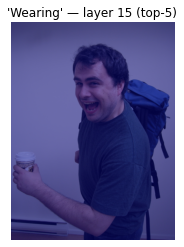

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

img = load_image(img_path)
img_width, img_height = img.size

target_word = "Wearing"
layer_idx = 15
top_k = 5

logits = torch.matmul(
    hidden_states[layer_idx].half(),
    lm_head.half().to(hidden_states.device).T
).squeeze(0)  # [576, vocab_size]

tids = tokenizer.encode(target_word, add_special_tokens=False)

topk_ids = logits.topk(top_k, dim=-1).indices  # [576, top_k]
in_topk = torch.isin(topk_ids, torch.tensor(tids).to(logits.device))
patch_has_word = in_topk.any(dim=-1)  # [576]

word_heatmap = logits[:, tids].max(dim=-1).values  # [576]
word_heatmap = word_heatmap * patch_has_word.float()
word_heatmap = word_heatmap.detach().cpu().float().numpy().reshape(24, 24)

segmentation_resized = np.array(
    Image.fromarray(word_heatmap).resize((img_width, img_height), Image.BILINEAR)
)

fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=0.5)
ax.set_title(f"'{target_word}' — layer {layer_idx} (top-{top_k})")
ax.axis('off')
plt.show()

In [ ]:
tokenizer.encode(target_word)[1:]
tokenizer.decode(16096)

'inspect'